# Churn Prediction - Telecom Case
Author: Daniel Grzebyk

Date: 1.07.2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix,classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from classification_utils import chi_test, chi_test_new, find_boolean_features, find_correlated_features, remove_outliers, plot_learning_curve

## Loading the data

In [2]:
selected_features = ['mou_opkv_Mean','months', 'uniqsubs', 'actvsubs', 'hnd_price', 'truck', 'rv', 'adults', 'income',
                     'eqpdays','new_cell', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'marital', 'infobase',
                     'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'churn']
# selected_features = ['eqpdays', 'months', 'mou_opkv_Mean', 'hnd_price', 'churn']

df = pd.read_csv("../data/telecom/data.csv", usecols=selected_features)
var_df = pd.read_csv("../data/telecom/variables-definition.csv")

In [3]:
X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

In [4]:
X.shape

(100000, 22)

### Investigating Correlations
1. Removing features correlated with other features
2. Removing features uncorrelated with churn (label)

#### Categorical Features

In [5]:
cat_features = X.select_dtypes(include='object').columns
cat_features

Index(['new_cell', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'marital',
       'infobase', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17'],
      dtype='object')

In [6]:
cat_features = X.select_dtypes(include='object').columns

my_x = X[cat_features].dropna().copy()
my_y = y.loc[my_x.index]

one_hot = OneHotEncoder(sparse=False)  # handle_unknown='ignore'
my_x_enc = one_hot.fit_transform(my_x)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(my_x_enc, my_y)

X_train_chi = chi2_selector.transform(my_x_enc)

In [7]:
feature_names = one_hot.get_feature_names(cat_features)

chi_df = pd.DataFrame({"feature": feature_names, "score": chi2_selector.scores_, "p_value": chi2_selector.pvalues_})
chi_df.loc[chi_df['p_value'] < 0.05].sort_values(by='p_value', ascending=True).head()

C:\Users\danie\anaconda3\envs\data_analysis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,score,p_value
29,hnd_webcap_WC,311.278190,1.150221e-69
27,refurb_new_R,71.981433,2.172317e-17
16,area_NORTHWEST/ROCKY MOUNTAIN AREA,64.364388,1.034105e-15
30,hnd_webcap_WCMB,58.362259,2.180338e-14
22,dualband_N,52.025357,5.478853e-13


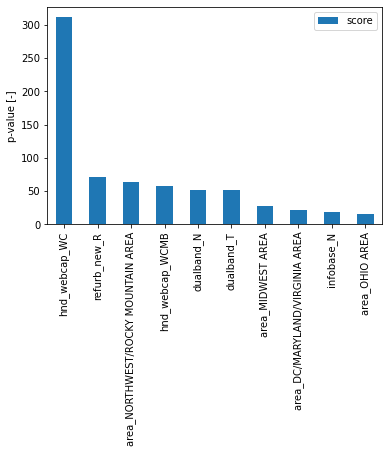

In [8]:
chi_df.nsmallest(10, columns=['p_value']).plot(x='feature', y='score', kind='bar')
plt.xlabel("")
plt.ylabel("p-value [-]")
plt.show()

#### Numerical features
Continous numerical features are also investigated looking for correlations.

In [9]:
num_features = df.select_dtypes(include='number').columns
num_features

Index(['mou_opkv_Mean', 'churn', 'months', 'uniqsubs', 'actvsubs', 'hnd_price',
       'truck', 'rv', 'adults', 'income', 'eqpdays'],
      dtype='object')

<AxesSubplot:>

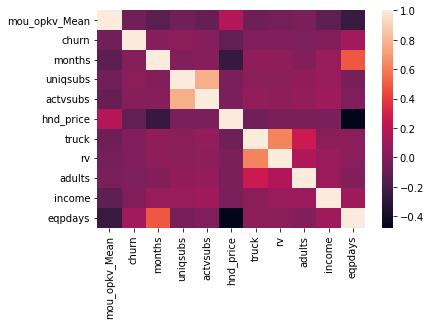

In [10]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix)

## Data Preprocessing
### Removing duplicates

In [11]:
X.duplicated().sum()

25

In [12]:
X.drop_duplicates(inplace=True)

### Removing outliers

In [13]:
def remove_outliers_iqr(X, cols):
    for col in cols:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        X.loc[mask, col] = np.nan
    return X

In [14]:
num_features = X.select_dtypes(include='number').columns
X = remove_outliers_iqr(X, num_features)

### Removing NaNs
Some columns have so many missing values that keeping them would leave us with too small dataset. Therefore, firstly entire columns with too many missing values are removed and then NaNs are dropped per row. 

In [15]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 10000].sort_values(ascending=False)  # Is one of the dropped features crucial?

income        25418
adults        23001
infobase      22061
truck         20287
hnd_webcap    10187
dtype: int64

In [16]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 10000].index)  # drop features which have more than 20% NaNs
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['hnd_webcap', 'truck', 'adults', 'infobase', 'income']
Before dropping rows with NaNs: (99975, 17)
After dropping rows with NaNs: (75009, 17)


### Looking for class imbalance

In [17]:
y.value_counts()

0    37693
1    37316
Name: churn, dtype: int64

In [18]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns
len(num_features), len(cat_features)

(7, 10)

## Predicting churn

### Splitting the data

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(60007, 17)

### Training the model

In [21]:
# %%time
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ("var_thr", VarianceThreshold(threshold=0.1))]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("cat_selector",  SelectKBest(chi2, k=5))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ],
    remainder = 'passthrough',
    n_jobs=-1
)

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", (GradientBoostingClassifier()))]
)

# pipeline.fit(X_train, y_train)
# print("model score: %.3f" % pipeline.score(X_val, y_val))

In [30]:
%%time
# GRADIENT BOOSTING
hyperparameter_grid = {
    'classifier__n_estimators': [10, 50, 100, 150, 200],
    'classifier__learning_rate': [1, 3, 10, 30, 100],
    'classifier__subsample': [0.3, 0.6, 0.9, 1],
    'classifier__max_depth': [5, 10, 20]
}


random_cv = RandomizedSearchCV(estimator=pipeline,
            param_distributions=hyperparameter_grid,
            cv=3, 
            n_iter=5,
            scoring = 'precision',
            n_jobs = -1,
            verbose = 0,
            error_score='raise',
            return_train_score = True,
            random_state=42)


random_cv.fit(X_train, y_train)

CPU times: total: 10.4 s
Wall time: 3min 8s


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=-1,
                                                                remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('var_thr',
                                                                                                VarianceThreshold(threshold=0.1))]),
                                                                               Index(['mou_opkv_Mean', 'months', 'uniqsubs', 'actvsubs', 'hnd_price', 'rv',
       'eqpdays'],
      dtype='object')),
                                                                              (...
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17'],
      dtype='object'))])),
                                             ('classifier',
                                              GradientBoostingClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [1, 3, 10,
                                                                      30, 100],
                                        'classifier__max_depth': [5, 10, 20],
                                        'classifier__n_estimators': [10, 50,
                                                                     100, 150,
                                                                     200],
                                        'classifier__subsample': [0.3, 0.6, 0.9,
                                                                  1]},
                   random_state=42, return_train_score=True,
                   scoring='precision')

In [31]:
random_cv.best_params_

{'classifier__subsample': 0.6,
 'classifier__n_estimators': 100,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 1}

### Inference

In [32]:
# Train Inference
y_pred = random_cv.best_estimator_.predict(X_train) # selector.estimator_ # random_cv.best_estimator_
y_val_pred = random_cv.best_estimator_.predict(X_val) # selector.estimator_ # random_cv.best_estimator_

### Evaluation

In [33]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 0.66
Train Precision: 0.65
Train Recall: 0.68

Validation Accuracy: 0.57
Validation Precision: 0.57
Validation Recall: 0.6


## Error Analysis / Postprocessing

### Feature Importance

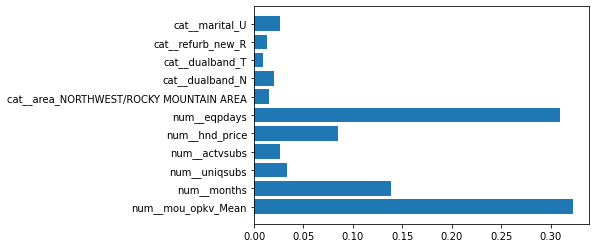

In [27]:
feature_names = random_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = random_cv.best_estimator_.steps[1][1].feature_importances_
plt.barh(width=feature_importances, y=feature_names)
plt.show()

In [28]:
# feature_names = selector.estimator_[:-1].get_feature_names_out()
# feature_importances = selector.estimator_.steps[1][1].feature_importances_
# plt.barh(width=feature_importances, y=feature_names)

### Learning Curve

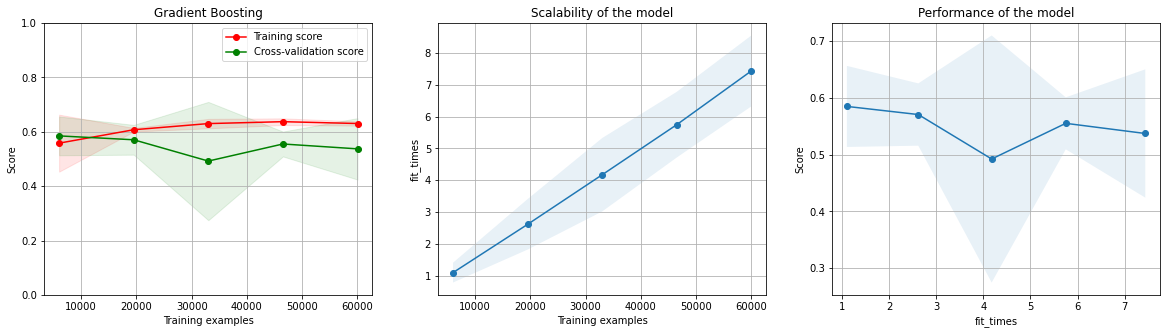

In [29]:
plot_learning_curve(estimator=random_cv.best_estimator_,
                    title='Gradient Boosting',  # Random Forest
                    X=X, 
                    y=y, 
                    axes=None, 
                    ylim=[0, 1], 
                    cv=5, 
                    n_jobs=-1, 
                    scoring='recall',
                    train_sizes=np.linspace(.1, 1.0, 5))
plt.show()